Context: this code sample was completed for a skills assessment at a previous position, and is used with their permission. 

The dataset describes a list of crime reports, and some have been classified as pertaining to a home invasion. I was tasked with creating a machine learning model to classify the unknown descriptions according to whether they described a home invasion or not. 

This code sample is meant to be a quick highlight of my pre-processing/machine learning abilities. 

In [1]:
import pandas as pd
import numpy as np
import re
import sklearn 

In [2]:
alls = pd.read_csv("allegations.csv", sep = '|')
alls.head(10)

,cr_id,text,home_invasion
0,1042384,It is reported that the involved officer and h...,NaN
1,1042532,It is reported that Officers Sierra and Mosque...,NaN
2,1043217,IT IS REPORTED THAT THE INVOLVED MEMBER DISCOV...,NaN
3,1043569,It is reported that the involved member was re...,NaN
4,1043812,The involved officers attempted to stop a vehi...,NaN
5,1044135,"It is reported that the subject, Dion Richards...",NaN
6,1044692,It is reported that while the offender was han...,NaN
7,1045186,It is reported the involved officer/victim was...,0.0
8,1045352,It is reported that during a narcotic investig...,NaN
9,1045759,It is reported that the involved officer obser...,NaN


In [3]:
len(alls.index)

19138

# 1. Prepare data 

   1a. preprocess

In [4]:
def preprocess(sentence):
    sentence = sentence.lower()
    sentence = re.sub("/", " ", sentence)
    sentence = re.sub("[^A-Za-z ]", "", sentence)
    return sentence

In [5]:
alls['text'] = alls['text'].apply(preprocess)

In [6]:
reviewed_alls = alls[(alls['home_invasion'] == 0) | (alls['home_invasion'] == 1)]
reviewed_alls.head()

,cr_id,text,home_invasion
7,1045186,it is reported the involved officer victim was...,0.0
10,1047231,it is reported that during a foot pursuit the ...,0.0
13,1047919,it is reported that the involved officer and h...,0.0
17,1048962,the victim alleges that an unknown male black ...,0.0
19,1048966,the reporting party victim stated that she tel...,0.0


In [7]:
np.mean(reviewed_alls['home_invasion']) # 7% of cases involve home invasion - imbalanced classes

0.07123775601068566

In [8]:
len(reviewed_alls.index) # n = 2246 

2246

1b. vectorize (using bag of words with count for simplicity, but there is a lot you could play around with here in terms of lemmatization, inculding 2 or 3 word phrases rather than just words, different methods of vectorization, etc.) 

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
x = vectorizer.fit_transform(reviewed_alls['text'])
x = x.toarray()

1c. split into test/train

In [10]:
from sklearn.model_selection import train_test_split
np.random.seed(2021)
x_train, x_test, y_train, y_test = train_test_split(x, reviewed_alls['home_invasion'], test_size = .2)

In [11]:
len(x_train[0]) # features

8349

In [12]:
len(x_train) # samples

1796

# 2. Fit models

For the sake of brevity, we're going to evaluate 2 models
1. Naive Bayes - simple (don't have to do a lot of tuning), and good baseline to compare other models to
2. Random Forest - can easily handle a lot of features without a lot of samples, lots of opportunities for tuning hyperparameters if needed 

And use cross-validation instead of a validation set since we have a relatively small sample size 

2a. Naive Bayes

In [13]:
from sklearn.naive_bayes import MultinomialNB 
from sklearn.model_selection import cross_val_predict

nb = MultinomialNB()
y_pred = cross_val_predict(nb, x_train, y_train)

/Users/seb2244/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


In [14]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_train, y_pred)
conf_mat

array([[1649,   11],
       [  43,   93]])

In [15]:
from sklearn.metrics import f1_score
f1_score(y_train, y_pred)

0.7749999999999999

2b. Random Forest

In [16]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

In [17]:
# select best hyperparameters using grid search

rf = RandomForestClassifier()
# define search space
space = dict()
space['n_estimators'] = [100, 200, 500] 
space['min_samples_leaf'] = [1, 2]
space['max_features'] = [200, 400, 600]

# search 
search = GridSearchCV(rf, space, scoring='f1', n_jobs =-1, cv=5, refit=False) # figure out how to use refit 
search.fit(x_train,y_train) 

# visualize results 
pd.DataFrame(search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_min_samples_leaf,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,14.502527,0.184738,0.096057,0.019846,200,1,100,"{'max_features': 200, 'min_samples_leaf': 1, '...",0.925926,0.857143,0.897959,0.808511,0.875000,0.872937,0.039603,10
1,25.313945,1.322230,0.098301,0.025431,200,1,200,"{'max_features': 200, 'min_samples_leaf': 1, '...",0.923077,0.857143,0.875000,0.833333,0.826087,0.862962,0.034747,13
2,61.397486,1.552098,0.253089,0.039455,200,1,500,"{'max_features': 200, 'min_samples_leaf': 1, '...",0.943396,0.857143,0.897959,0.808511,0.800000,0.861447,0.054140,14
3,10.765029,0.551164,0.051038,0.006429,200,2,100,"{'max_features': 200, 'min_samples_leaf': 2, '...",0.857143,0.782609,0.875000,0.800000,0.650000,0.792986,0.079295,18
4,21.481986,0.665990,0.123327,0.028061,200,2,200,"{'max_features': 200, 'min_samples_leaf': 2, '...",0.857143,0.755556,0.826087,0.772727,0.772727,0.796882,0.038380,17
5,52.231904,1.693824,0.293007,0.098535,200,2,500,"{'max_features': 200, 'min_samples_leaf': 2, '...",0.901961,0.782609,0.851064,0.826087,0.744186,0.821226,0.054531,16
6,20.268893,2.537302,0.055703,0.005034,400,1,100,"{'max_features': 400, 'min_samples_leaf': 1, '...",0.943396,0.857143,0.880000,0.816327,0.897959,0.879001,0.042236,4
7,35.619176,0.840223,0.097257,0.014800,400,1,200,"{'max_features': 400, 'min_samples_leaf': 1, '...",0.945455,0.857143,0.897959,0.816327,0.897959,0.883003,0.043515,1
8,87.003818,2.669436,0.170745,0.015624,400,1,500,"{'max_features': 400, 'min_samples_leaf': 1, '...",0.945455,0.857143,0.897959,0.816327,0.851064,0.873629,0.044327,8
9,16.606303,1.231102,0.047876,0.003151,400,2,100,"{'max_features': 400, 'min_samples_leaf': 2, '...",0.945455,0.857143,0.875000,0.816327,0.800000,0.858833,0.051087,15


In [18]:
# build a random forest based on the best parameters 
rf_clf = RandomForestClassifier(**search.best_params_) 
y_pred = cross_val_predict(rf_clf, x_train, y_train)

/Users/seb2244/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


In [19]:
conf_mat = confusion_matrix(y_train, y_pred)
conf_mat

array([[1654,    6],
       [  26,  110]])

In [20]:
f1_score(y_train, y_pred)

0.873015873015873

There are still a lot more false negatives than false positives, so depending on the real-world ramifications for these categories we could adjust the threshold for declaring something a home invasion. However without any outside context, I'm pretty happy with this f-score compared to how naive bayes scored, so let's move on. 

# 3. final evaluation on test data for the model selected

In [21]:
rf_clf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features=400, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [22]:
y_pred = rf_clf.predict(x_test)

In [23]:
conf_mat = confusion_matrix(y_test, y_pred)
conf_mat

array([[426,   0],
       [  1,  23]])

In [24]:
f1_score(y_test, y_pred)

0.9787234042553191

In [28]:
from sklearn.tree import export_graphviz
export_graphviz(rf_clf.estimators_[0],
                filled=True,
                rounded=True)

'digraph Tree {\nnode [shape=box, style="filled, rounded", color="black", fontname=helvetica] ;\nedge [fontname=helvetica] ;\n0 [label="X[6408] <= 0.5\\ngini = 0.147\\nsamples = 1136\\nvalue = [1652, 144]", fillcolor="#e78c4a"] ;\n1 [label="X[3393] <= 0.5\\ngini = 0.099\\nsamples = 1049\\nvalue = [1564, 86]", fillcolor="#e68844"] ;\n0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;\n2 [label="X[2408] <= 0.5\\ngini = 0.077\\nsamples = 999\\nvalue = [1510, 63]", fillcolor="#e68641"] ;\n1 -> 2 ;\n3 [label="X[2919] <= 1.5\\ngini = 0.049\\nsamples = 981\\nvalue = [1505, 39]", fillcolor="#e6843e"] ;\n2 -> 3 ;\n4 [label="X[2530] <= 1.0\\ngini = 0.042\\nsamples = 979\\nvalue = [1505, 33]", fillcolor="#e6843d"] ;\n3 -> 4 ;\n5 [label="X[2528] <= 1.0\\ngini = 0.037\\nsamples = 975\\nvalue = [1504, 29]", fillcolor="#e6833d"] ;\n4 -> 5 ;\n6 [label="X[5620] <= 0.5\\ngini = 0.03\\nsamples = 972\\nvalue = [1504, 23]", fillcolor="#e5833c"] ;\n5 -> 6 ;\n7 [label="X[8000] <= 1.0\\ngini = 0.02

In [31]:
os.system('dot -Tpng tree.dot -o tree.png')

32512

In [33]:

from sklearn import tree

In [35]:
tree.plot_tree(rf_clf.estimators_[0],
               filled = True)

[Text(415.14520547945204, 361.9, 'X[6408] <= 0.5\nentropy = 0.147\nsamples = 1136\nvalue = [1652, 144]'),
 Text(356.03287671232874, 346.49999999999994, 'X[3393] <= 0.5\nentropy = 0.099\nsamples = 1049\nvalue = [1564, 86]'),
 Text(315.26575342465753, 331.09999999999997, 'X[2408] <= 0.5\nentropy = 0.077\nsamples = 999\nvalue = [1510, 63]'),
 Text(288.0876712328767, 315.7, 'X[2919] <= 1.5\nentropy = 0.049\nsamples = 981\nvalue = [1505, 39]'),
 Text(277.21643835616436, 300.29999999999995, 'X[2530] <= 1.0\nentropy = 0.042\nsamples = 979\nvalue = [1505, 33]'),
 Text(255.4739726027397, 284.9, 'X[2528] <= 1.0\nentropy = 0.037\nsamples = 975\nvalue = [1504, 29]'),
 Text(244.60273972602738, 269.5, 'X[5620] <= 0.5\nentropy = 0.03\nsamples = 972\nvalue = [1504, 23]'),
 Text(222.86027397260273, 254.09999999999997, 'X[8000] <= 1.0\nentropy = 0.023\nsamples = 966\nvalue = [1498, 18]'),
 Text(211.9890410958904, 238.7, 'X[450] <= 0.5\nentropy = 0.021\nsamples = 965\nvalue = [1498, 16]'),
 Text(201.1178

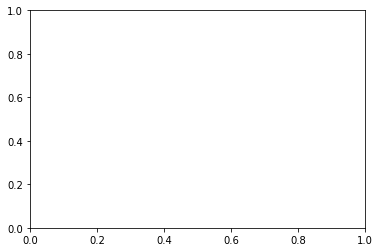

In [38]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows = 1,ncols = 1)
fig.savefig('rf_individualtree.png')